# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [227]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [228]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [229]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [230]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [231]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [232]:
#https://pastebin.com/JWeQkDwi notes   
#https://pastebin.com/ntk9Ekhp
subset = []
for column in list(df_reviews.columns):
    if df_reviews[df_reviews[column].isna() == True][column].shape[0] > 0:
        print(df_reviews[column].dropna().reset_index(drop=True))
        subset.append(column)
df_reviews = df_reviews.dropna(subset=subset).reset_index(drop=True)

0        6.3
1        6.3
2        6.3
3        6.3
4        6.3
        ... 
47324    7.7
47325    7.3
47326    7.3
47327    7.3
47328    7.3
Name: average_rating, Length: 47329, dtype: float64
0        2218
1        2218
2         184
3         184
4         184
         ... 
47324    2254
47325     278
47326     278
47327     278
47328     278
Name: votes, Length: 47329, dtype: Int64


In [233]:
df_reviews.info()
#print(df_reviews.iloc[47329])
#print(df_reviews.iloc[47330])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47329 entries, 0 to 47328
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

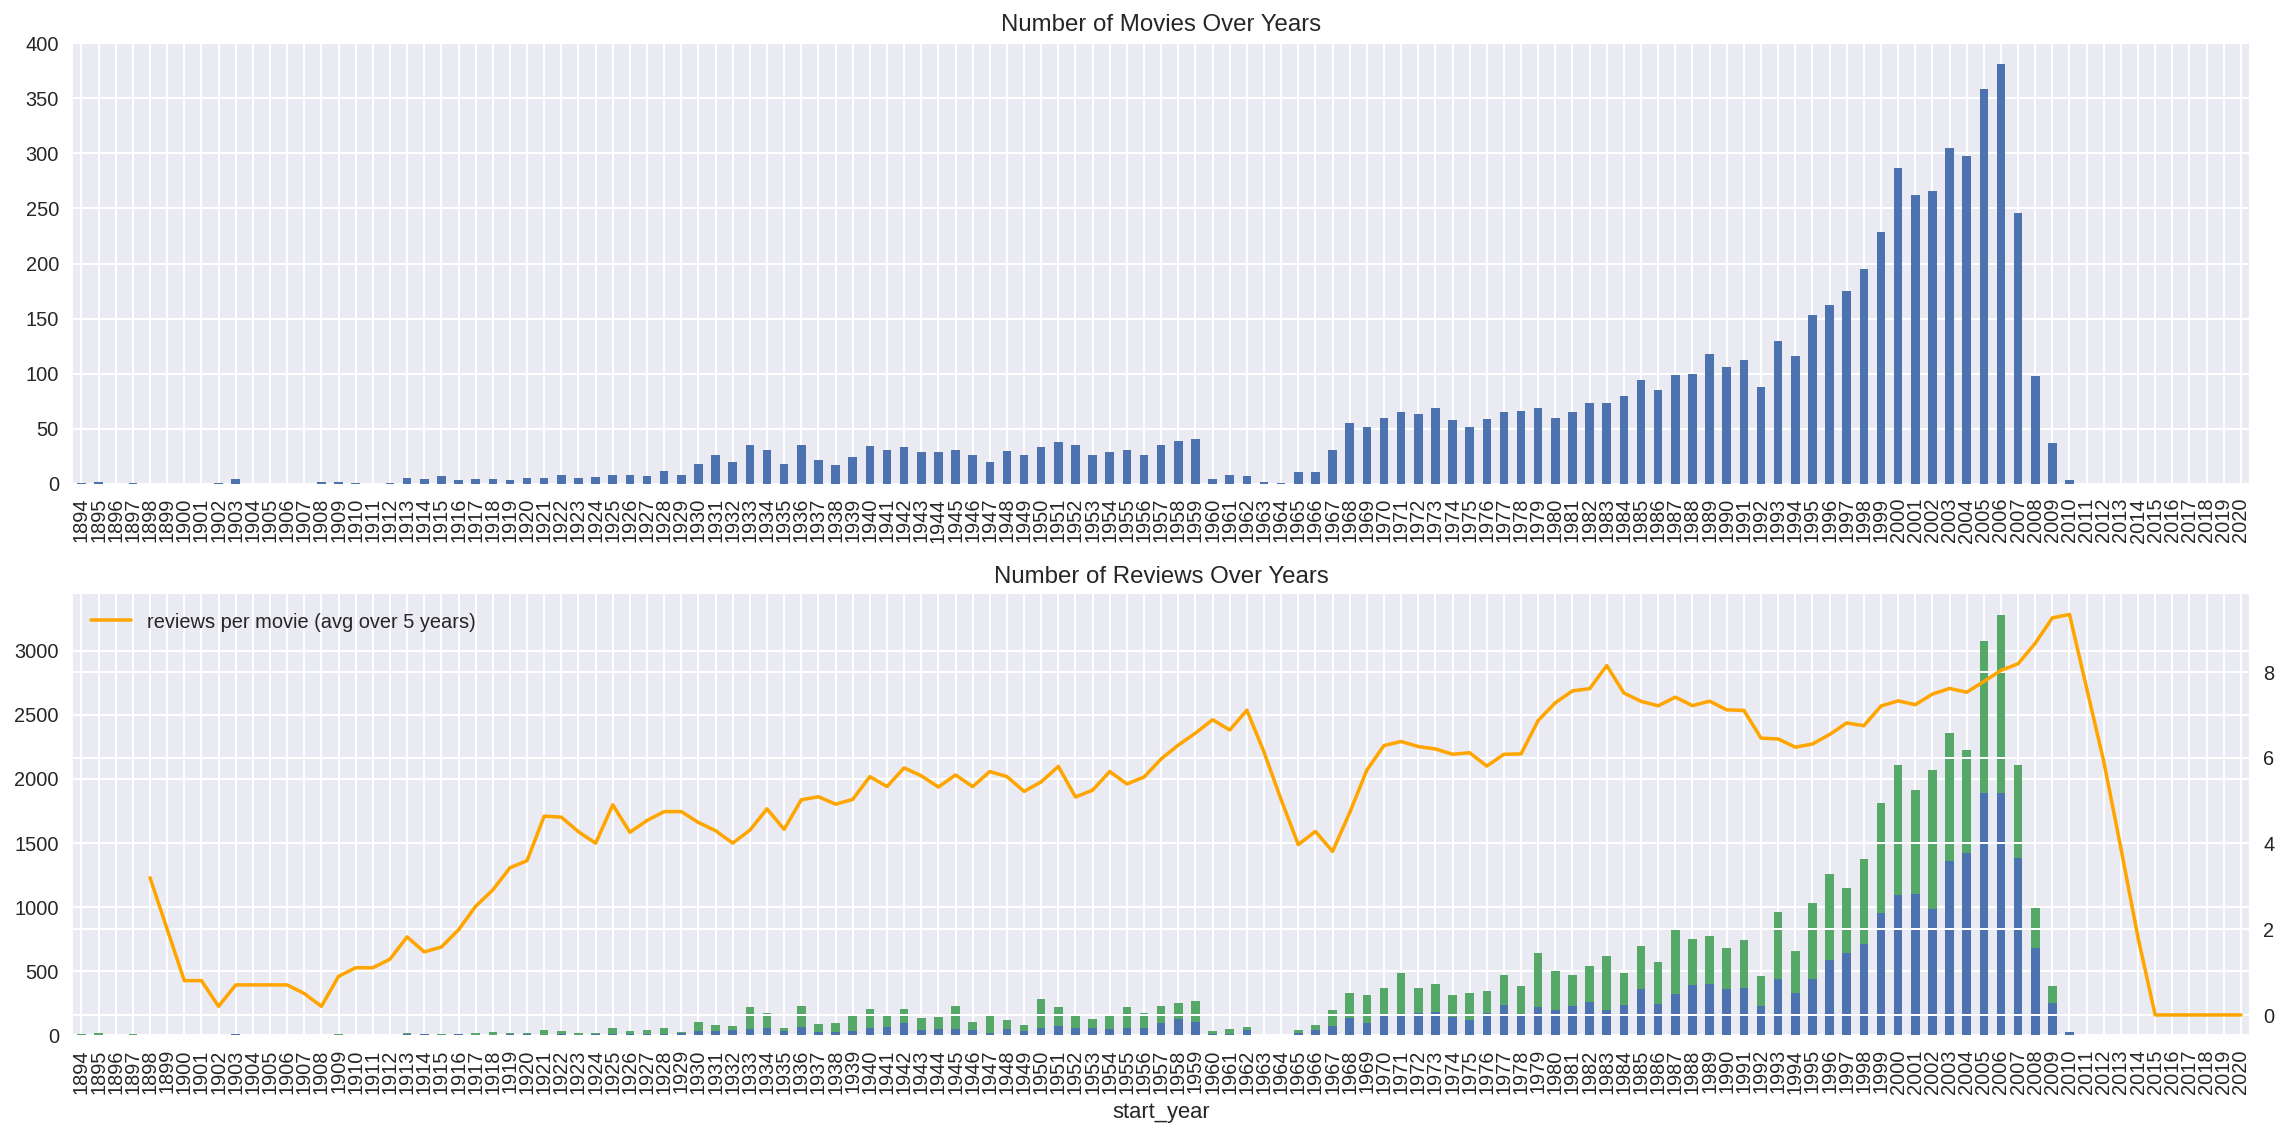

In [234]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')
   
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

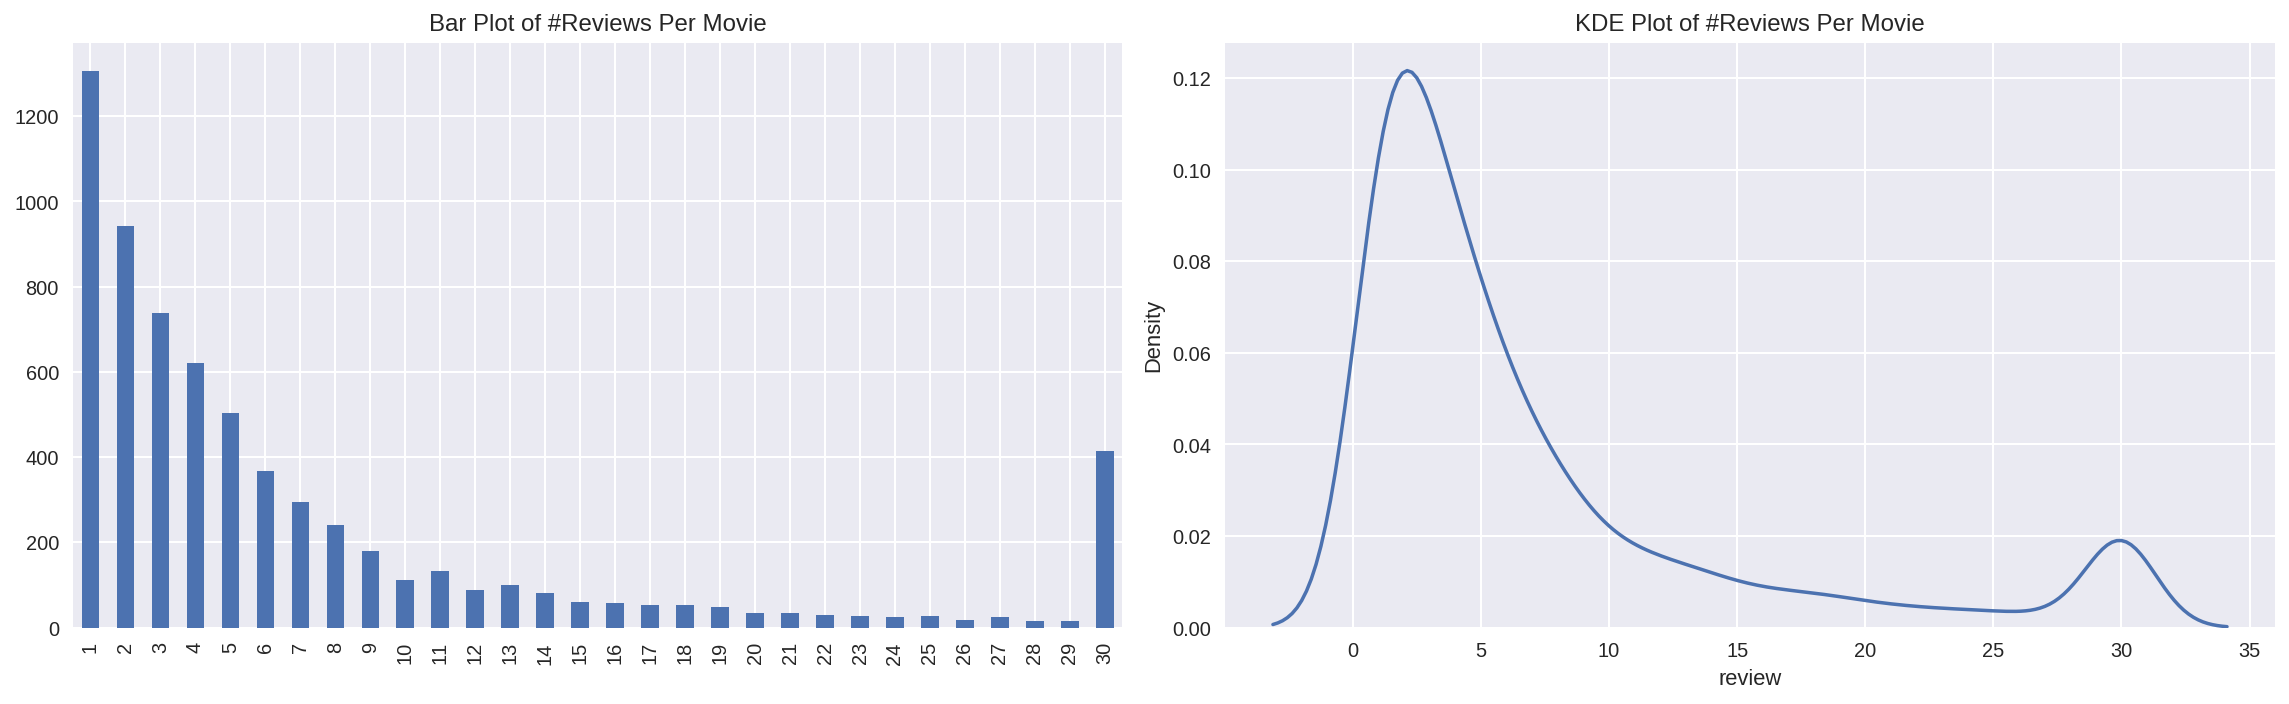

In [235]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

One review per movie, very right skewing data with the outlier being 30 reviews per movie.

In [236]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

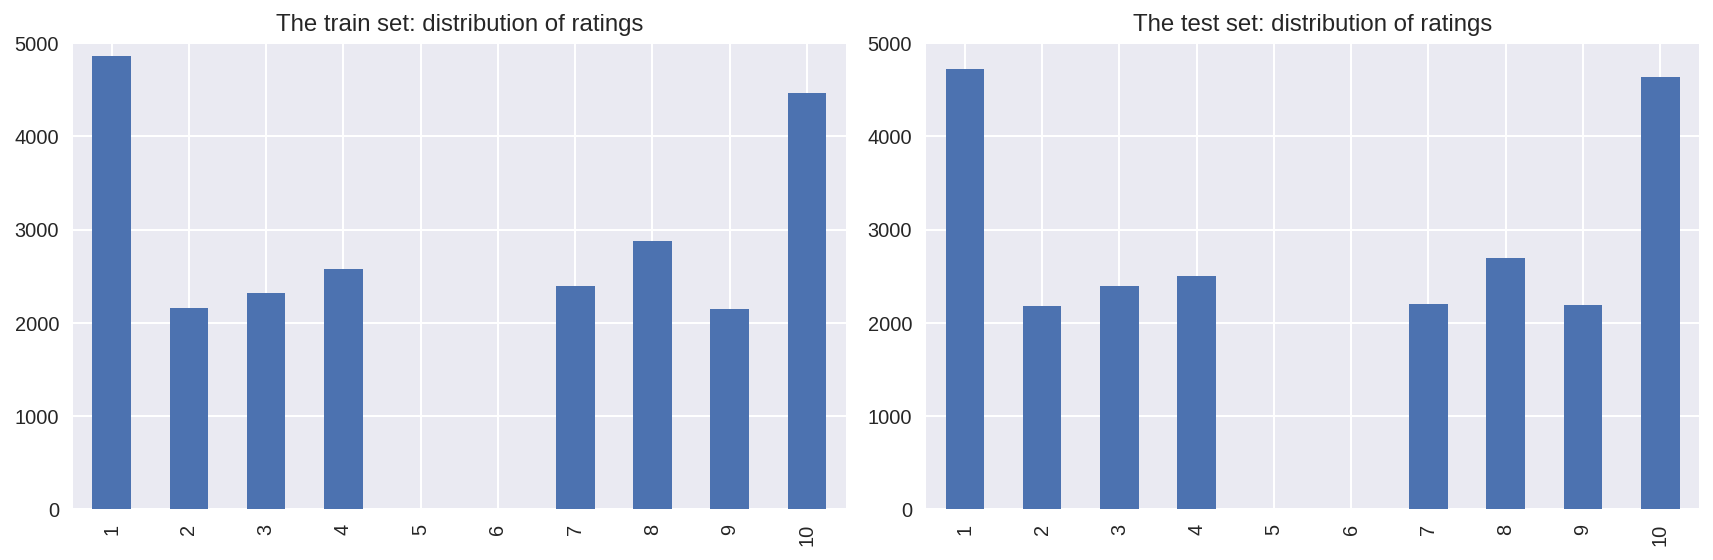

In [237]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

An almost perfectly even distribution between both the training and test set.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


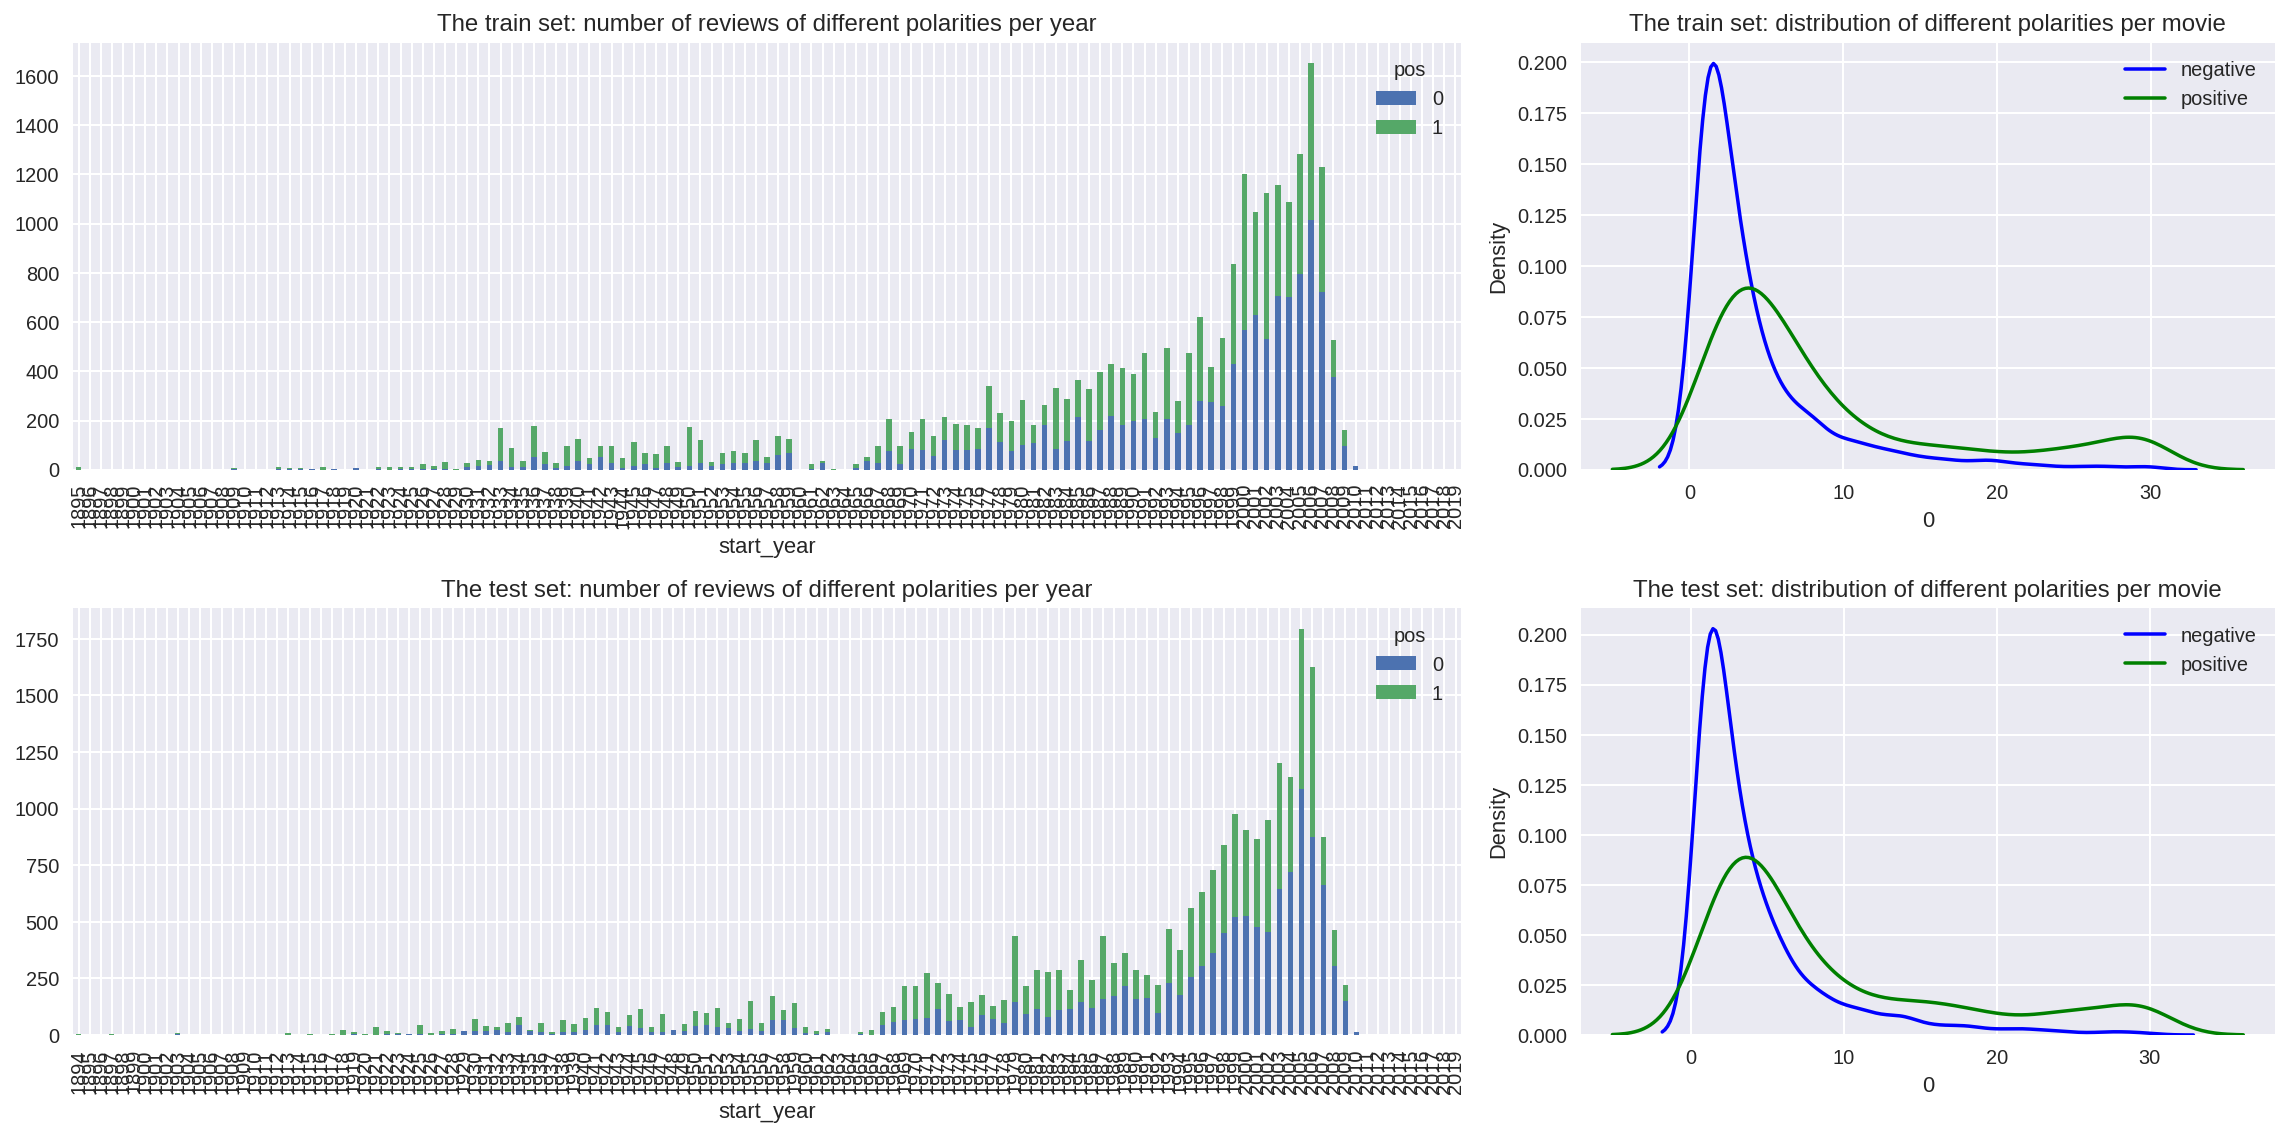

In [238]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The max positive and negative reviews increased over time. But the number of overall number of negative reviews is rarely above 5. More positive reviews than negative reviews overall, however the more reviews a movie has the more positive reviews appear than negatives. The less reviews a movie has the more likely it will have a negative review.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [239]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [240]:
import re
def clear_text(text):
    
    # < write code here >
    text = text.lower()
    #All the letters that match the pattern are listed in square brackets without spaces and can be placed in any order. Let's find letters from a to z. If we assume they can be in both lowercase and uppercase, then the code should be written as follows:
    pattern = r"[^a-zA-Z']"
    
    #if we call re.sub(pattern, ' ', text), all letters and apostrophes will be substituted, but we need to keep them. To indicate that we want to find characters that don't match the pattern, put a caret ^ at the beginning of the sequence. Here's how it will look:
    
    text = re.sub(pattern, " ", text)
    
    #Now we only have letters, apostrophes and spaces left, although, we seem to have more spaces than we need. In the next step, let's get rid of the extra spaces, since they can hinder our analysis. We can eliminate them by using a combination of the methods join() and split().
    #We can use the split() method to convert our string into a list. If we call split() without any arguments, it splits the text at the spaces or groups of spaces:
    text = text.split()
    
    #Using the join() method, we then recombine these elements into a string with spaces:
    
    text = ' '.join(text)
    
    text = ' '.join(text.split())
    
    return text

#df_reviews()

print(df_reviews['review'].head(5))

df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)  # <put your code here>
print(df_reviews['review_norm'].head(5))

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object
0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [241]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [242]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


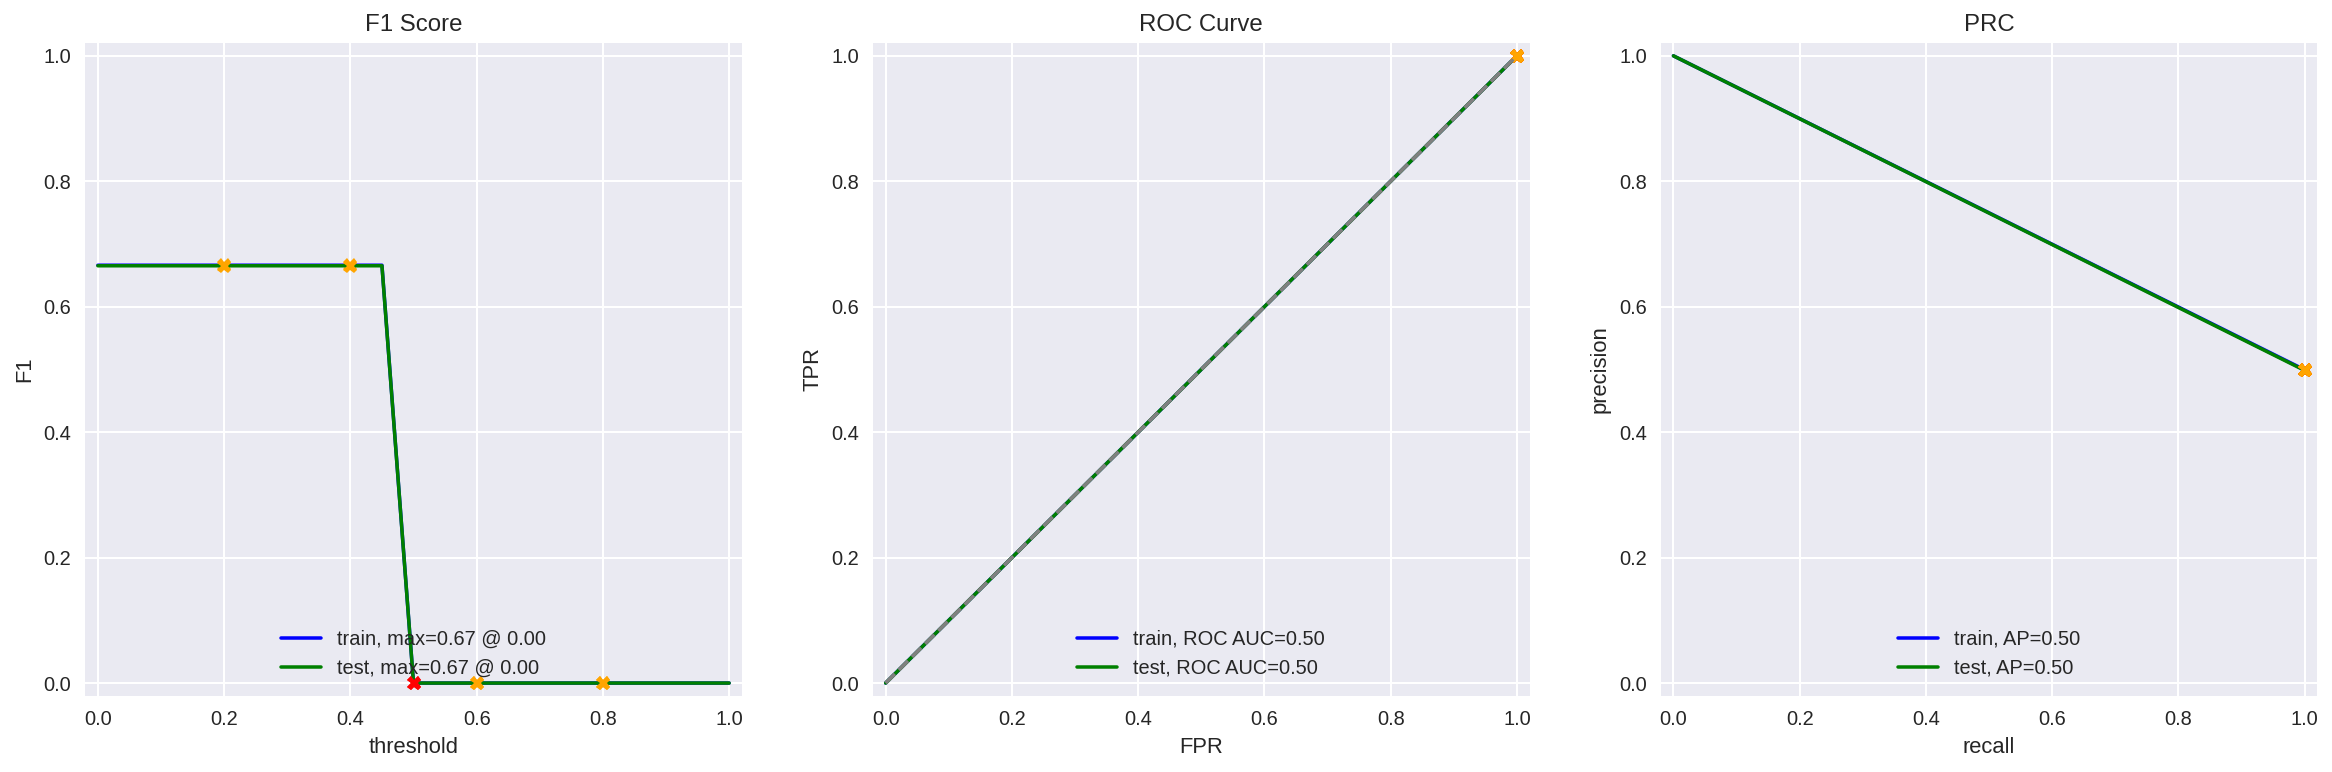

In [243]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

model = DummyClassifier()
model.fit(train_features,train_target)
#print(model.predict(features_test))

evaluate_model(model, train_features, train_target, test_features, test_target)

The f1_score() function takes correct answers and predictions and returns the harmonic mean of recall and precision. 
We put the FPR values along the horizontal axis, and TPR values along the vertical axis. Then we iterate over the logistic regression threshold values and plot a curve. This is the ROC curve (Receiver Operating Characteristic)

For a model that always answers randomly, the ROC curve is a diagonal line going from the lower left to the upper right. The higher the curve, the greater the TPR value and the better the model's quality.

On the graph the precision value is plotted vertically and horizontally. A curve plotted from Precision and Recall values is called a PR curve. The higher the curve, the better the model.

Ok accuracy. Terrible F1 score. Low ROC curve. Low Precision Recall curve. It's only a dummy. Train is also same as test.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [244]:
import nltk

#You can calculate the TF-IDF by using the sklearn library. The TfidfVectorizer() class can be found in the sklearn.feature_extraction.text module. Import it this way:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [245]:
stop_words = set(stopwords.words('english')) 

count_tf_idf = TfidfVectorizer(stop_words=stop_words)

train_features_1 = count_tf_idf.fit_transform(df_reviews_train['review_norm'])
#remember, you don't need to fit the test_features or it will ruin the data.
test_features_1 = count_tf_idf.transform(df_reviews_test['review_norm'])

#print(train_features_1)
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)
#print(model.predict(features_test))


LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


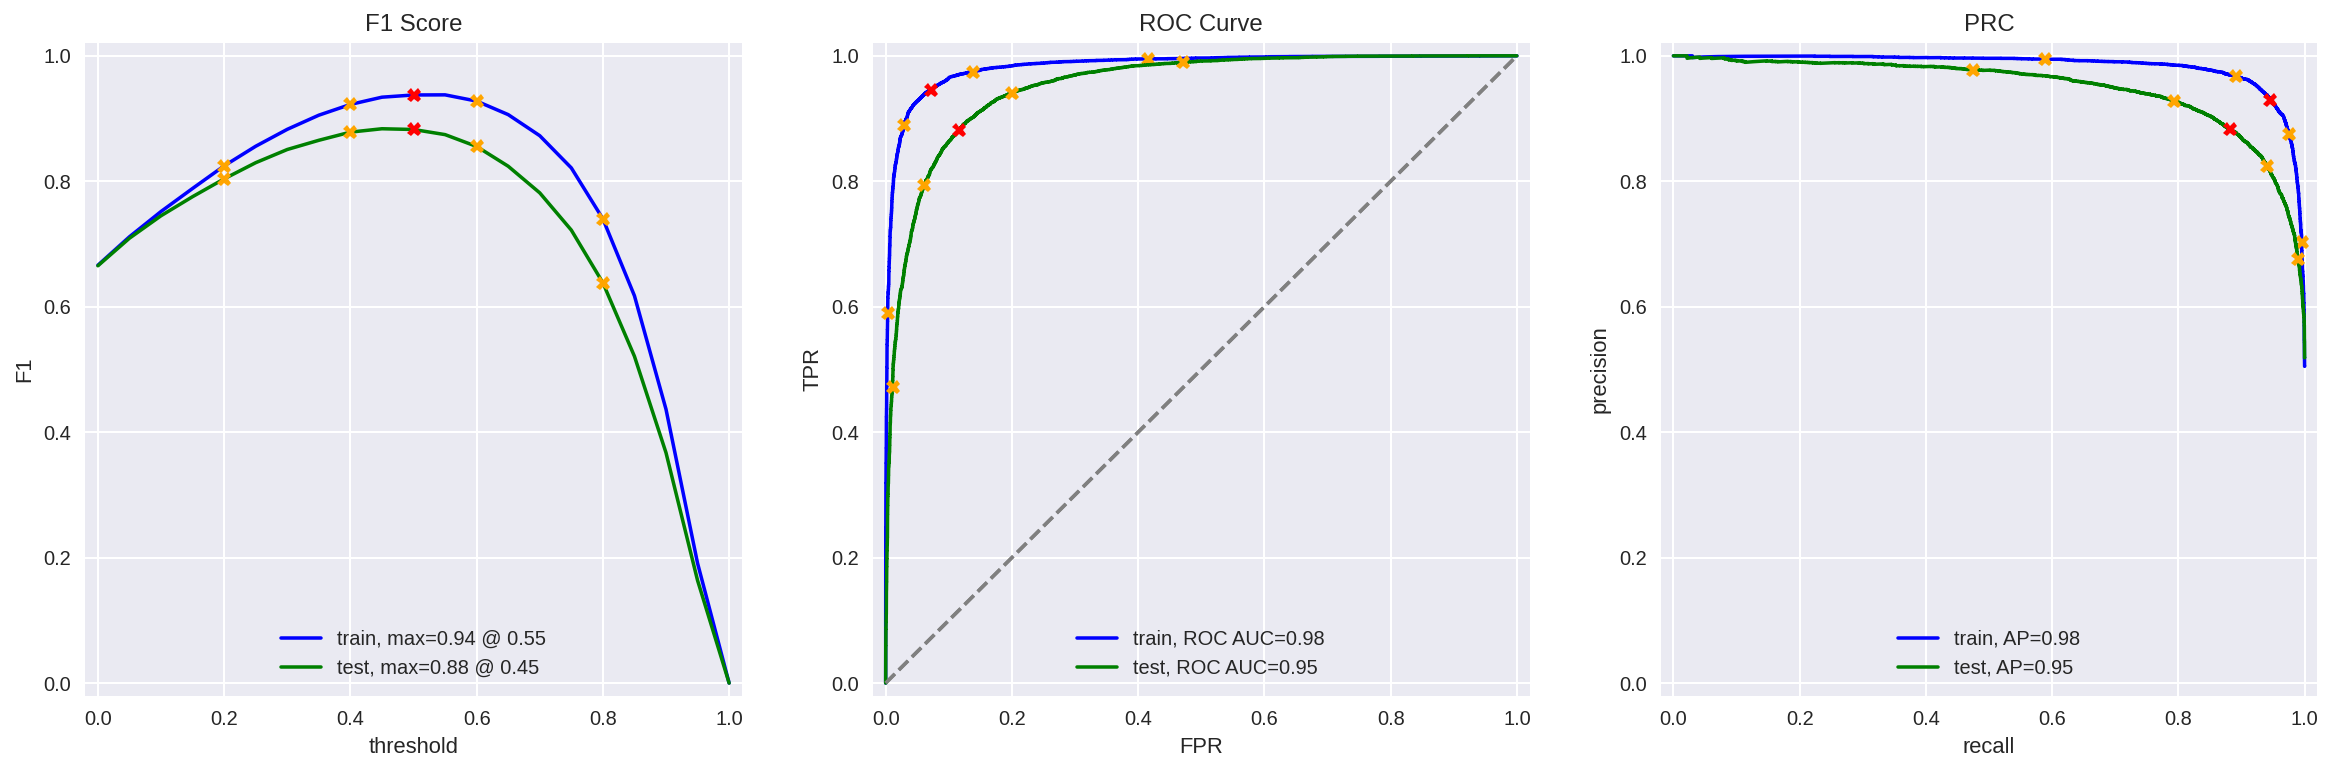

In [246]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Good test accuracy. High F1 score, ROC curve and PR Curve. Slightly lower as Test than Train, but still high.

### Model 3 - spaCy, TF-IDF and LR

In [247]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [248]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

This will be a little slow. Please wait.

In [249]:
train_features_2 = count_tf_idf.fit_transform(df_reviews_train['review_norm'].apply(text_preprocessing_3))
test_features_2 = count_tf_idf.transform(df_reviews_test['review_norm'].apply(text_preprocessing_3))

model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


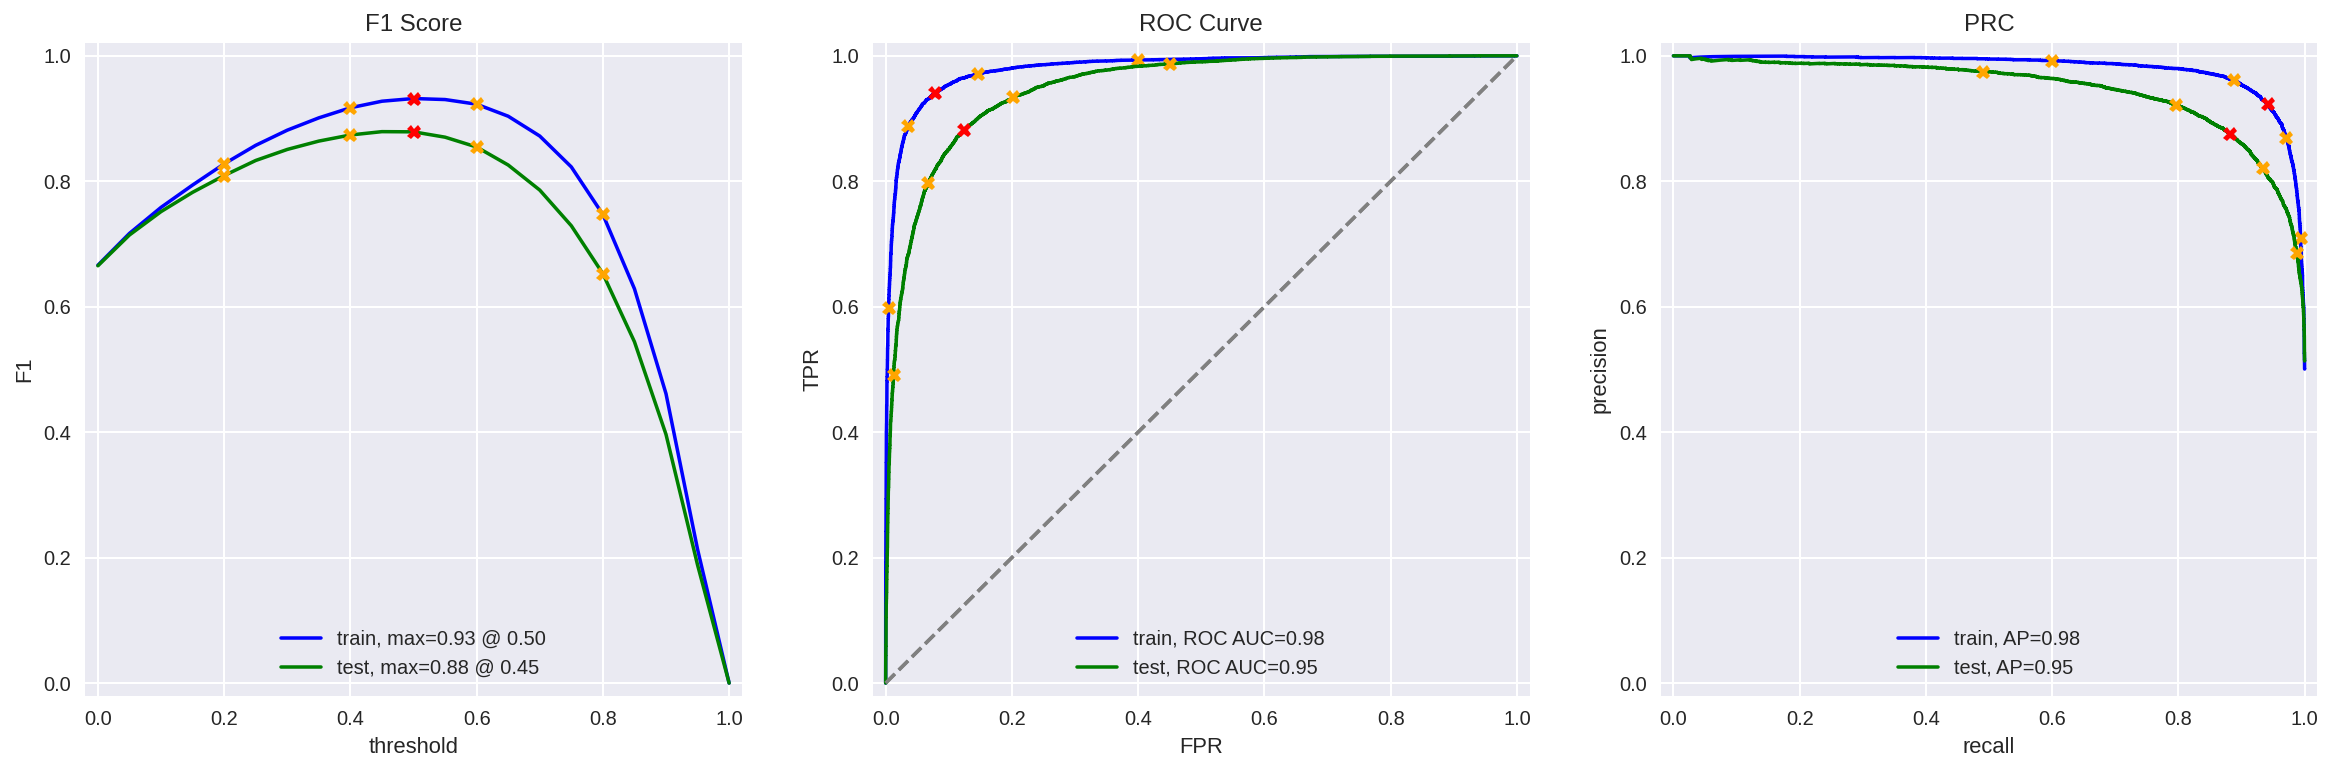

In [250]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [251]:
from lightgbm import LGBMClassifier

In [252]:
model_4 = LGBMClassifier()
model_4.fit(train_features_2,train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


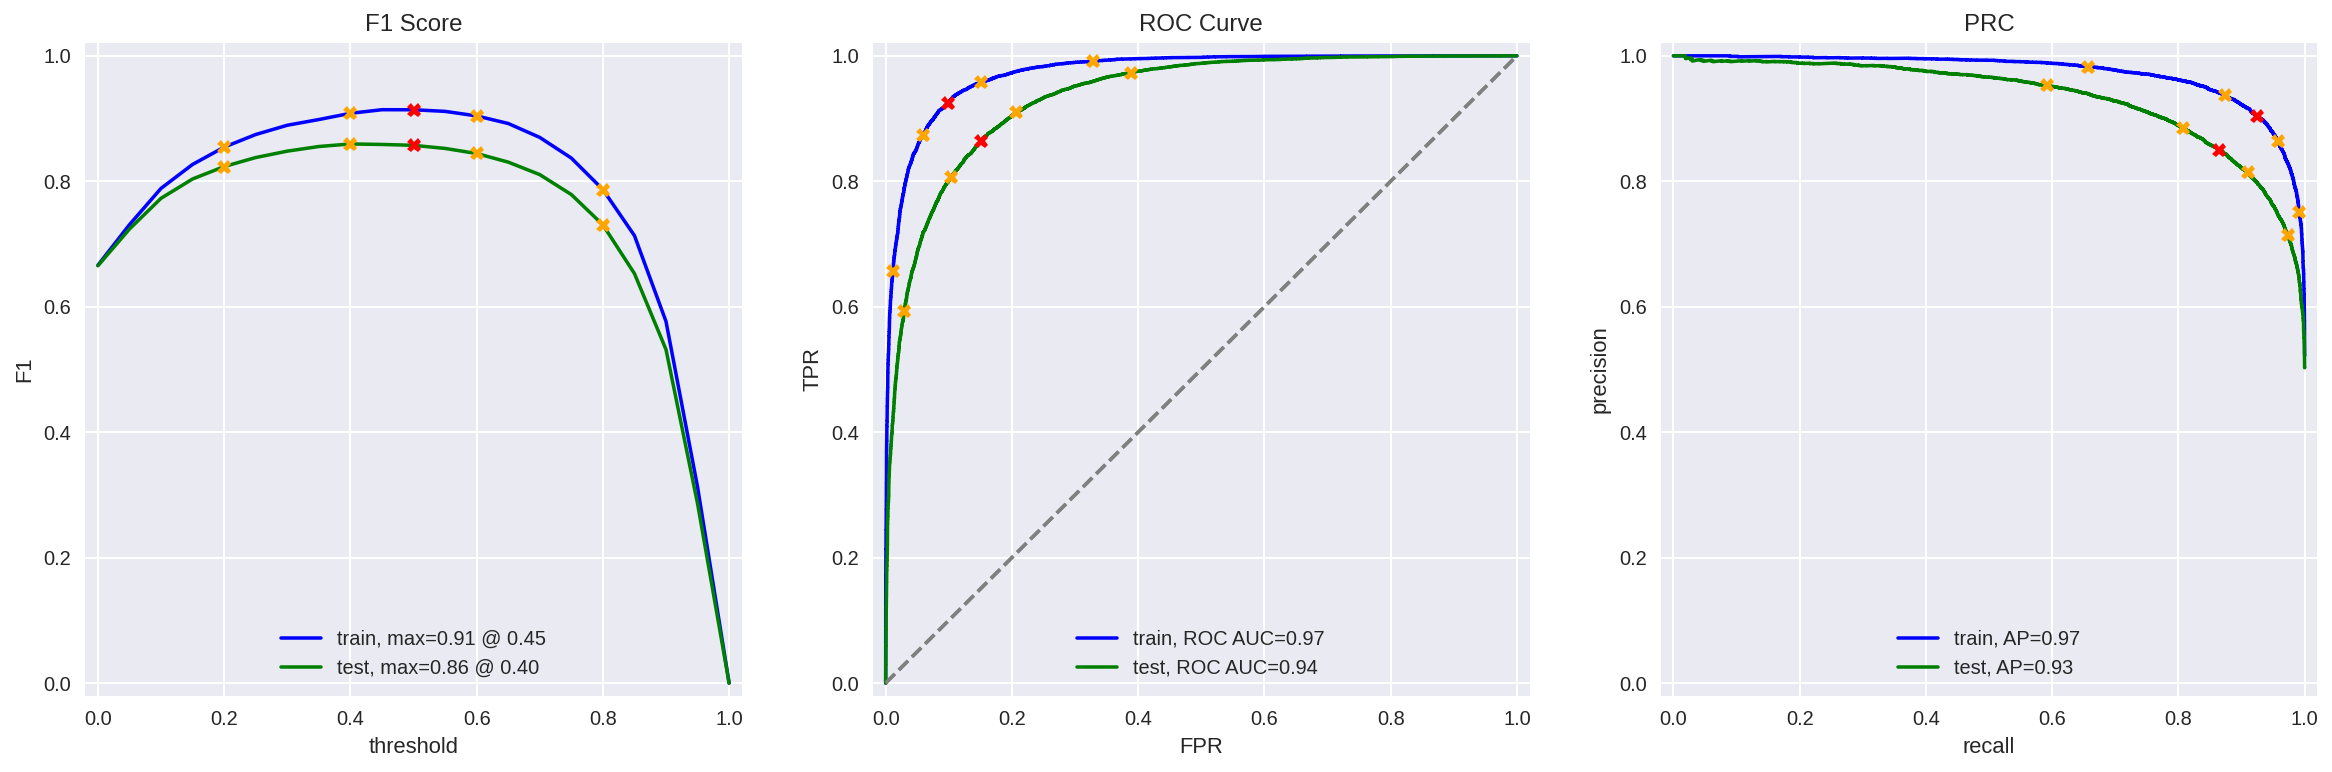

In [253]:
evaluate_model(model_4, train_features_2, train_target, test_features_2, test_target)  

Overall lesser test scores than LinearRegression. 

## My Reviews

In [254]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text) # <put here the same normalization logic as for the main dataset>

my_reviews

review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0      i did not simply like it not my kind of movie  
1  well i was bored and felt asleep in the middle...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn't expect the reboot to be so good write...  
5  the movie had its upsides and downsides but i ...  
6  what a rotten attempt at a comedy not a single...  
7  launching on netflix was a brave move i really...

### Model 1

Text blocks were readded to prevent ValueError

In [255]:
stop_words = set(stopwords.words('english')) 

count_tf_idf = TfidfVectorizer(stop_words=stop_words)

train_features_1 = count_tf_idf.fit_transform(df_reviews_train['review_norm'])

model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)



LogisticRegression()

In [256]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

Long load

In [257]:
train_features_2 = count_tf_idf.fit_transform(df_reviews_train['review_norm'].apply(text_preprocessing_3))

model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

LogisticRegression()

In [258]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [259]:
model_4 = LGBMClassifier()
model_4.fit(train_features_2,train_target)

LGBMClassifier()

In [260]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = count_tf_idf
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  i did not simply like it not my kind of movie
0.40:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.38:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.73:  i didn't expect the reboot to be so good writers really cared about the source material
0.61:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

Model 3 was the best. Both with review and evaluation. The high F1 score, Precision-Recall Curve and AUC ROC Curve as well as seeing it in action with random reviews, proves it is the best of the 3 models. This is in part due to normalization and lemmatization and LinearRegression being superior to LightGBM classifier in handling text.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions